# Sketchy

Purpose: This notebook provides a walk through the process of retrieving photos of the same class as a hand-drawn sketch with the model proposed in [Doodle to Search: Practical Zero-Shot Sketch-based Image Retrieval](http://dagapp.cvc.uab.es/doodle2search/CVPR2019.pdf). 
Complementary information and studies on the model can be found in [here](http://dagapp.cvc.uab.es/doodle2search/CVPR2019_Supplementery.pdf).

Contrarily to the paper above, we perform here a non-zero shot inference, which means that the classes in training, validation and testing are the same (only sketches and images are different). Moreover, we did not implement all the parts associated with the semantic loss. Further explanation are èrovided in the model description part.

## Package Import

In [1]:
#!git clone https://https://github.com/VisiumCH/AMLD-2021-Sketchy.git

#%cd AMLD-2021-Sketchy/notebooks/
%pwd

'/home/pauline.maury/AMLD-2021-Sketchy/notebooks/workshop'

In [2]:
# Python imports
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.metrics import average_precision_score
from torch.utils.data import DataLoader
from torchvision import transforms

# Codebase imports
from src.data.loader_factory import load_data
from src.data.utils import default_image_loader
from src.models.encoder import EncoderCNN
from src.models.inference.inference import Inference
from src.models.test import get_part_of_test_data
from src.models.utils import get_model, normalise_attention, get_parameters, load_checkpoint

## Model description

### Quick overview

The photo retrieval task aims to return photos that are in the same class as sketches drawn by hand.

Therefore, two encoders are trained: one for the photos and one for the sketches. Each encoder maps its input (photo or sketch) to an embedding space E (with E=256 dimensions).

Then, the embeddings are ranked by similarity based on their euclidean distance in the embedding space and the most similar photos to the sketch  are retrieved.

<img src="images/graph.png">

### Problem Formulation
$C$: set of all possible categories

$X = \{x_i\}^N_{i=1}$: set of photos

$Y = \{y_i\}^M_{i=1}$: set of sketches

$l_x : X → C$ and $l_y : Y → C$ are the two labelling functions for photos and sketches respectively.

Such that given an input sketch an optimal ranking of gallery images can be obtained.

### Encoder Networks
Given a distance function d(·, ·), the aim of the framework is to learn two embedding functions $Ф : X → R^D$ and $Ψ : Y → R^D$, which respectively map the photo and sketch domain into a common embedding space.

Given two photos $x_1, x_2 ∈ X$ and a sketch $y ∈ Y$, it is expected that the embeddings fulfill the following condition:

$$\begin{align}
& d(Ф(x_1), Ψ(y)) < d(Ф(x2), Ψ(y)), \\
& when \quad l_x(x_1) = l_y(y) \\
& and \quad l_x(x_2) ≠ l_y(y) \\
\end{align}$$

meaning that there is a shorter distance when photos and sketch belong to the same class. Here, $d$ is the euclidean distance.

The embedding function $Ф(·)$ and $Ψ(·)$ are defined as two CNNs (VGG 16) with attention where the last fully-connected layer has been replaced to match the embedding size E. The attention mechanism helps the system
to localise the important features and is learned end-to-end with the rest of the network. The output of the attention module is computed by $f + f * att$.

### Learning Objectives



The learning objective of the framework combines two losses: the <i>Triplet Loss</i> and the <i>Domain Loss</i>.

$\{a, p, n\}$ 
where $a ∈ Y^s$, $p ∈ X^s$ and $n ∈ X^s$ are respectively the anchor, positive and negative samples during
the training and $l_x(p) = l_y(a)$ and $l_x(n) ≠ l_y(a)$.

#### Triplet loss: 
This loss aims to reduce the distance between embedded sketch and image if they belong to the same class and increase it if they belong to different classes.

Defining distance between samples as $δ_+ = ||Ψ(a) − Ф(p)||_2$ and $δ_- = ||Ψ(a) − Ф(n)||_2$ for the positive and negative samples respectively, then, the ranking loss for a particular triplet can be formulated as $λ(δ_+, δ_−) = max\{0, µ+δ_+ −δ_−\}$ where $µ > 0$ is a margin parameter. 

Batch-wise, the loss is defined as:
$$\begin{align}
& L_t = \sum_{i=1}^{N} λ(δ^i_+, δ^i_-) \\
\end{align}$$

 
the order aimed by this loss is $δ_− > δ_+ + µ$, if this is the case, the network is not updated, otherwise, the weights of the network are updated accordingly.

#### Domain loss:
This loss aims to explicitly enforce the mapping of sketch and image samples to a common space.

Given the embedding $Ф(·)$ and $Ψ(·)$, we make use of a Multilayer Perceptron (MLP) as a binary classifier trying to predict which was the initial domain. Purposefully, in order to create indistinguishable embedding we use a GRL defined as $R_λ(·)$, which applies the identity function during the forward pass $R_λ(x) = x$,
whereas during the backward pass it multiplies the gradients by the meta-parameter $−λ$, $\frac{dR_λ}{dx}= −λI$. This operation reverses the sign of the gradient that flows through the CNNs. 

Following the notation,
$f : R^D → [0, 1]$ be the MLP and $e ∈ R^D$ an embedding coming from the encoders network. Then we can define the binary cross entropy of one of the samples as $l_t(e) = tlog(f(R_{λ_d}(e))) + (1 − t) log(1 − f(R_{λ_d}(e)))$, where $e$ is the embedding obtained by the encoder network and $t$ is 0 and 1 for sketch and photo domains respectively.
Hence, the domain loss is defined as:

$$\begin{align}
& L_d = \frac{1}{3N}\sum_{i=1}^{N} ( l_0(Ψ(a_i)) + l_1(Ф(p_i)) + l_1(Ф(n_i)) ) \\
\end{align}$$

See the paper for additional information.

## Coding

In [3]:
class Args:
    dataset = "sketchy"
    data_path = '../../io/data/raw/'
    save = '../../io/models/sktu_copy/'
    load = save + 'checkpoint.pth'
    embeddings_path = save + '00053/default/'
    
    emb_size = 256
    cuda = False
    seed = 42
    
    max_images_test = 10
    training_split = 0.8
    valid_split = 0.1
    batch_size = 10
    prefetch = 2
    attn = True

In [4]:
args = Args()
# Note: the code here is simplifies, only choose sketchy or quickdraw as dataset.
assert args.dataset in ['sketchy', 'quickdraw']

In [5]:
transform = transforms.Compose([transforms.ToTensor()])

### Performance study

We can compute the precision of our model with a few sketches and images.

In [6]:
# First we get the data loader of the test set 
_, [_, _], [test_sk_data, test_im_data], dict_class = load_data(args, transform)

sk_loader = DataLoader(test_sk_data,
                       batch_size=3 * args.batch_size,
                       num_workers=args.prefetch,
                       pin_memory=True)
im_loader = DataLoader(test_im_data,
                       batch_size=3 * args.batch_size,
                       num_workers=args.prefetch,
                       pin_memory=True)

In [7]:
# We create the model
im_net = EncoderCNN(out_size=args.emb_size, attention=args.attn)
sk_net = EncoderCNN(out_size=args.emb_size, attention=args.attn)

# And load the weight of the best checkpoint
checkpoint = load_checkpoint(args.load)
im_net.load_state_dict(checkpoint["im_state"])
sk_net.load_state_dict(checkpoint["sk_state"])

=> loading model '../../io/models/sktu_copy/checkpoint.pth'
=> loaded model '../../io/models/sktu_copy/checkpoint.pth' (epoch 49, map 0.3094873427878774)


<All keys matched successfully>

In [8]:
# As it is quite slow, we only load 10*10*3 images and 10*10*3 sketches (can be changed below, higher is better)
args.max_images_test = 10
im_fnames, im_embeddings, im_class = get_part_of_test_data(im_loader, im_net, args, 0)
sk_fnames, sk_embeddings, sk_class = get_part_of_test_data(sk_loader, sk_net, args, 0)

Now we compute the similarity values between images and sketch (complete the function get_similarity below)

In [9]:
def get_similarity(sk_embeddings, im_embeddings):
    '''
    Computes images and sketch similarity in the feature space.
    The distance is computed as the euclidean distance. 
    Here, we want similarity = 1/(1 + distance)
    Args:
        - sk_embeddings: embeddings of the sketches [1xE]
        - im_embeddings: embeddings of the images [MxE]
    Return:
        - similarity: similarity value between images and sketches embeddings [NxM]
    '''
    # Hint: use scipy cdist
    
    # TODO
    # return ...
    return 1/(1 + cdist(sk_embeddings, im_embeddings, 'euclidean')) # correction

In [10]:
similarity = get_similarity(sk_embeddings, im_embeddings)

We check the labels of the loaded sketches and embeddings. 1 where the label and sketch match and 0 otherwise. (complete the function compare_classes below)

In [11]:
def compare_classes(class_im, class_sk):
    '''
    Compare classes of images and sketches
    Args:
        - class_im: list of classes of the images [M]
        - class_sk: list of classes of the sketches [N]
    Return:
        - array [MxN] of 1 where the image and sketch belong to the same class and 0 elsewhere
    '''
    class_sk = np.expand_dims(class_sk, axis=1)
    class_im = np.expand_dims(class_im, axis=0)
    # TODO
    # return ...
    return (class_sk == class_im)*1 # correction

In [12]:
class_matches = compare_classes(im_class, sk_class)

We sort the images based on their similarity with sketches (most similar to least similar)

In [13]:
arg_sorted_sim = (-similarity).argsort()
sorted_similarity = []  # list of similarity values ordered by similarity (most to least similar)
sorted_lst = []  # list of class target ordered by similarity (0 if different, 1 if same)
for indx in range(0, arg_sorted_sim.shape[0]):
    sorted_similarity.append(similarity[indx, arg_sorted_sim[indx, :]])
    sorted_lst.append(class_matches[indx, arg_sorted_sim[indx, :]])

sorted_similarity = np.array(sorted_similarity)
sorted_class_matches = np.array(sorted_lst)

We compute the mAP (mean average precision) and Precision@200 of the results.

In [25]:
# TODO
# Compute the mean average precision of all results
# Hint: you can use sklearn function average_precision_score
#map = ...
map = average_precision_score(sorted_class_matches, sorted_similarity)
print(f'The mean average precision of all samples is {np.round(map, 4)}.')

The mean average precision of all samples is 0.1985.


In [22]:
# TODO
# Compute the mean average precision of the 200 first results
#map_200 = ...
map_200 = average_precision_score(sorted_class_matches[:, 0:200], sorted_similarity[:, 0:200])
print(f'The mean average precision of the 200 most similar is {np.round(map_200, 4)}.')

The mean average precision of the 200 most similar is 0.2766.


In [21]:
# TODO
# Compute the Precision@200 (meaning the precision at the place 200th)
#prec_200 =..
prec_200 = np.mean(sorted_class_matches[:, 200])
print(f'The precision of the 200 most similar is {np.round(prec_200, 4)}.')

The precision of the 200 most similar is 0.0788.


### Inference function

We will see how to retrieve the closest images to a sketch here. We provide a list of sketch, and select a random one for the inference. 

The goal is to get the embedding and the sketch and match it with the closest image in the embedding space. In the web app, only the two closest images are shown. Here, we will plot the NUM_CLOSEST closest images.

In [124]:
# Number of closest images to retrieve. Feel free to modify it.
NUM_CLOSEST = 10

In [142]:
sketch_root = '../../io/data/raw/Quickdraw/sketches/'
sketch_fnames = ['ant/4531454526619648.png', 'alarm_clock/4506026491510784.png', 'axe/4505398503538688.png', 
                 'apple/4505772249579520.png', 'banana/4512982459482112.png', 'bee/4504274916605952.png', 
                 'bench/4506543531753472.png', 'cake/4507078863355904.png', 'cactus/4506460186738688.png',
                 'camel/4507169137360896.png', 'campfire/4505920430145536.png', 'car/4504613682151424.png', 
                 'church/4504994524954624.png', 'crocodilian/4505874796118016.png', 'dog/4505656939773952.png']

sketch_fnames = [sketch_root + sketch_fname for sketch_fname in sketch_fnames]
sketch_fname = sketch_fnames[np.random.randint(low=0, high=len(sketch_fnames))]

In [143]:
inference = Inference(args, 'test')

In [144]:
# Load the sketch
sketch = transform(default_image_loader(sketch_fname)).unsqueeze(0)  # unsqueeze because 1 sketch (no batch)

# Compute the embeddings and attention
sketch_embedding, attn_sk = inference.sk_net(sketch)

# Get the atention values normalised and sized as the sketch
attn_sk = normalise_attention(attn_sk, sketch)

In [146]:
similarity = get_similarity(sketch_embedding, inference.images_embeddings) # Done in performance part

# TODO
# Hint: sort from the index of the most to the least similar images and labels
# arg_sorted_sim = ...
arg_sorted_sim = (-similarity).argsort() # correction

In [147]:
# Get images and labels in ranked order
sorted_fnames = [inference.images_fnames[i] for i in arg_sorted_sim[0][0: NUM_CLOSEST + 1]]
sorted_labels = [inference.images_classes[i] for i in arg_sorted_sim[0][0: NUM_CLOSEST + 1]]

closest_images = [default_image_loader('../../' + sorted_fnames[i]) for i in range(NUM_CLOSEST)]
closest_labels = [inference.dict_class[str(sorted_labels[i])] for i in range(NUM_CLOSEST)]

# Get sketch and heatmap
sketch = mpimg.imread(sketch_fname)
heat_map = attn_sk.squeeze()

You can now code the function to get the full image. It should look like this: 
    <img src="images/example_ant.png">


In [148]:
# TODO

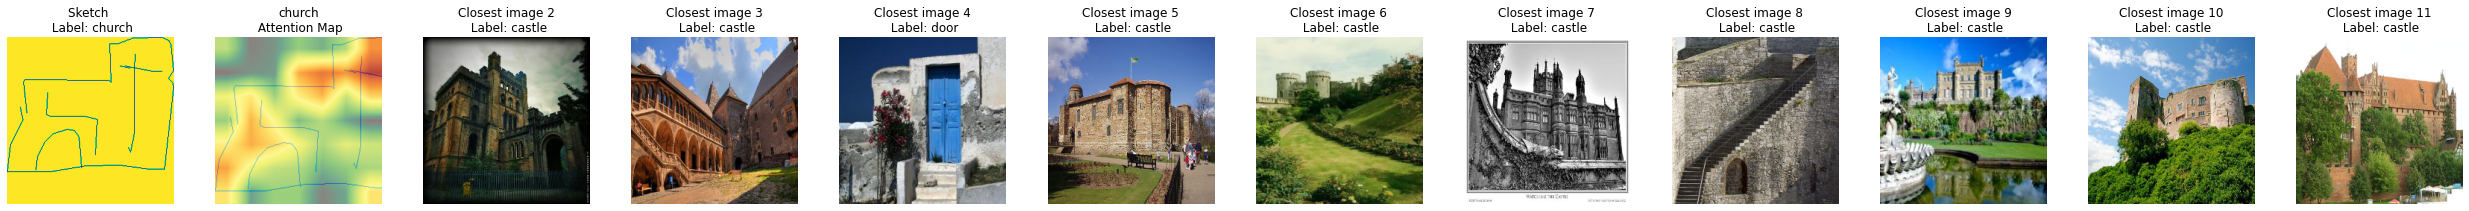

In [149]:
# Correction
fig, axes = plt.subplots(1, NUM_CLOSEST + 2, figsize=((NUM_CLOSEST + 1) * 4, 8))

sk = mpimg.imread(sketch_fname)
axes[0].imshow(sk)
axes[0].set(title="Sketch \n Label: " + sketch_fname.split("/")[-2])
axes[0].axis("off")

heat_map = attn_sk.squeeze()

axes[1].imshow(sk)
axes[1].imshow(255 * heat_map, alpha=0.7, cmap="Spectral_r")
axes[1].set(title=sketch_fname.split("/")[-2] + "\n Attention Map")
axes[1].axis("off")

for i in range(2, NUM_CLOSEST + 2):
    axes[i].imshow(closest_images[i-2])
    axes[i].set(title='Closest image ' + str(i) + '\n Label: ' + closest_labels[i-2])
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.25, hspace=-0.35)

### Server to make web app work

In [ ]:
# call appropriate function of inference